In [1]:

import pyprob
import numpy as np
import ot
import torch
import cProfile
import pickle

from pyprob.dis import ModelDIS
from showerSim import invMass_ginkgo
from torch.utils.data import DataLoader
from pyprob.nn.dataset import OnlineDataset
from pyprob.util import InferenceEngine
from pyprob.util import to_tensor
from pyprob import Model
import math
from pyprob.distributions import Normal
from pyprob.distributions.delta import Delta


import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as mpl_cm
plt.ion()

from sbi import utils
from sbi import analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn


import sklearn as skl
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from joblib import Parallel, delayed

from geomloss import SamplesLoss
sinkhorn = SamplesLoss(loss="sinkhorn", p=1, blur=.05)
def sinkhorn_t(x,y):
    x = torch.as_tensor(x)
    y = torch.as_tensor(y)
    return sinkhorn(x,y)

def ot_dist(x,y):
    x = x.detach().numpy()
    y = y.detach().numpy()
    a = ot.unif(len(x))
    b = ot.unif(len(y))
    Mat = ot.dist(x, y, metric='euclidean')
    distance = torch.tensor(ot.emd2(a,b,Mat))
    return distance



[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


## Prepare simulator

In [2]:
QCD_mass = to_tensor(30.)
#rate=to_tensor([QCD_rate,QCD_rate]) #Entries: [root node, every other node] decaying rates. Choose same values for a QCD jet
jetdir = to_tensor([1.,1.,1.])
jetP = to_tensor(400.)
jetvec = jetP * jetdir / torch.linalg.norm(jetdir) ## Jetvec is 3-momentum. JetP is relativistic p.


# Actual parameters
pt_min = to_tensor(0.3**2)
M2start = to_tensor(QCD_mass**2)
jetM = torch.sqrt(M2start) ## Mass of initial jet
jet4vec = torch.cat((torch.sqrt(jetP**2 + jetM**2).reshape(-1), jetvec))
minLeaves = 1
maxLeaves = 10000 # unachievable, to prevent rejections
maxNTry = 100


ginkgo_simulator = invMass_ginkgo.SimulatorModel(jet_p=jet4vec,  # parent particle 4-vector
                                    pt_cut=float(pt_min),  # minimum pT for resulting jet
                                    Delta_0= M2start,  # parent particle mass squared -> needs tensor
                                    M_hard=jetM,  # parent particle mass
                                    minLeaves=1,  # minimum number of jet constituents
                                    maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                                    suppress_output=True)

prior_min = [1e-3,1e-3]
prior_max = [30.,30.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

In [3]:
def theta_grid(num_x, num_y):
    
    x_coords = torch.linspace(prior_min[0], prior_max[0], num_x+2)[1:-1]
    y_coords = torch.linspace(prior_min[1], prior_max[1], num_y+2)[1:-1]

    return torch.cartesian_prod(x_coords, y_coords)

full_grid = theta_grid(8,8)
data = []
for theta in full_grid:
    data.append(ginkgo_simulator(theta)['leaves'])

In [4]:
def grid_ot_score(params):
    input = ginkgo_simulator(params)['leaves']
    distances = []
    for leaves in data:
        distances.append(ot_dist(input,leaves))
    return torch.tensor(distances)


In [5]:
ref_score_1 = grid_ot_score([3,3])
ref_score_2 = grid_ot_score([5,9])
ref_score_3 = grid_ot_score([10,10])

In [6]:
posterior=infer(grid_ot_score, prior, method='SNPE', 
                  num_simulations=5000, num_workers=7)

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 63 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

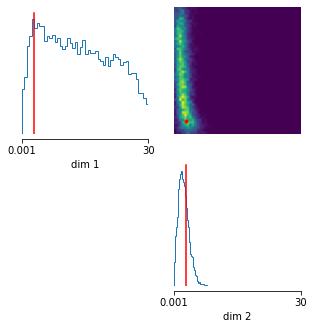

In [9]:
samples = posterior.sample((10000,),x=ref_score_1)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([3,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

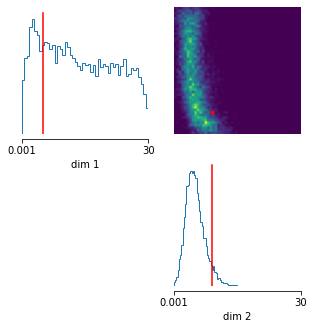

In [10]:
samples = posterior.sample((10000,),x=ref_score_2)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([5,9]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

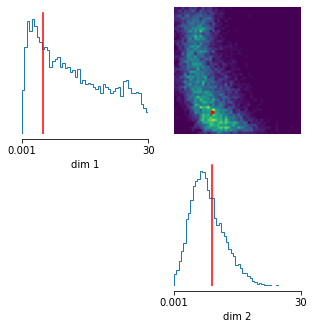

In [11]:
samples = posterior.sample((10000,),x=ref_score_3)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([5,9]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.[pyKeOps]: Warning, no cuda detected. Switching to cpu only.

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/ot/lp/__init__.py:495: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


 Neural network successfully converged after 58 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

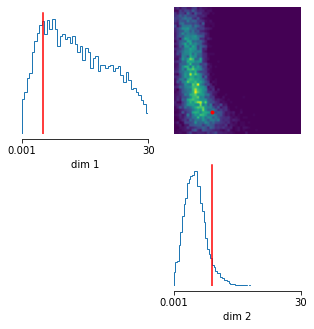

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 59 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

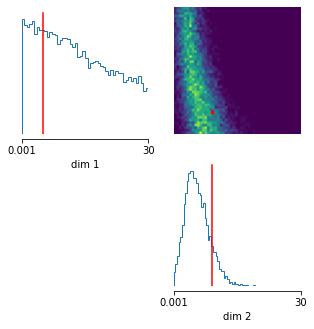

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

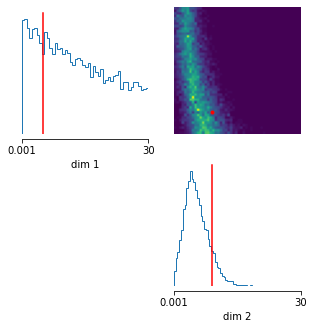

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

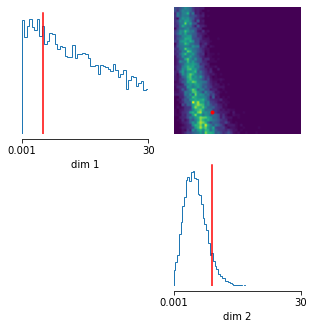

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

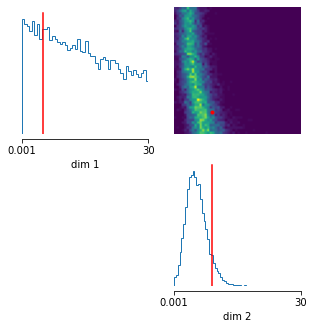

In [12]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(grid_ot_score, prior)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(ref_score_2)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[1e-3,30.], [1e-3,30.]],
                            ticks=[[1e-3,30.], [1e-3,30.]],
                            figsize=(5,5),
                            points=np.array([5,9]),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

## Include calibration kernel

Easiest to do this by appending an extra score, corresponding to the distance from true observations. This can then be used to inform the kernel weighting. Start by computing some fake observations.

In [13]:
true_params = torch.tensor([3,3])
synthetic_data = ginkgo_simulator(true_params)
synthetic_obs = synthetic_data['leaves']

true_params_2 = torch.tensor([5,9])
synthetic_data_2 = ginkgo_simulator(true_params_2)
synthetic_obs_2 = synthetic_data_2['leaves']

In [68]:
def full_score(params, input = None):
    if input is None:
        input = ginkgo_simulator(params)['leaves']
    distances = []

    distances.append(ot_dist(input,synthetic_obs))
    for leaves in data:
        distances.append(ot_dist(input,leaves))
    return torch.tensor(distances)

In [69]:
def kernel(xs): # Doesn't work
    
    distances = xs[:,0]
    var = torch.var(distances)

    def wrapped(x):
        return torch.exp(-0.5*x[:,0]**2/(var))
    
    return wrapped

ref_score_full_1 = full_score([0,0], synthetic_obs)
ref_score_full_2 = full_score([0,0], synthetic_obs_2)


Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 65 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

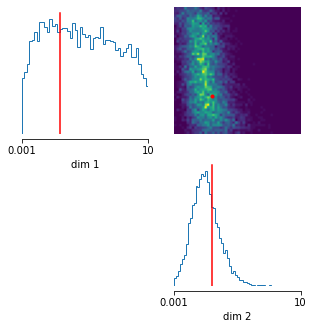

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

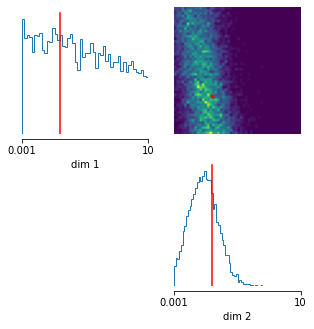

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

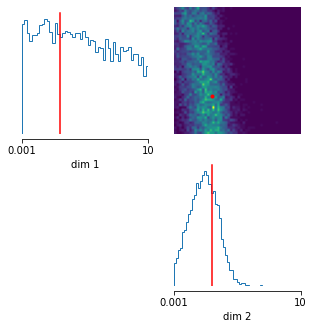

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

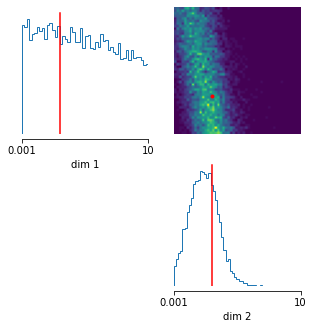

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Using SNPE-C with atomic loss
 Neural network successfully converged after 54 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

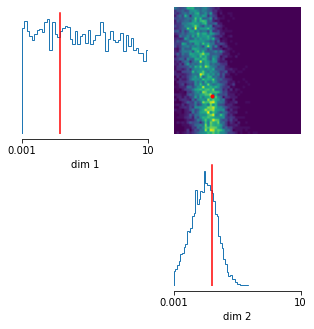

In [70]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(full_score, prior)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(calibration_kernel=kernel(inference.get_simulations()[1]))
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(ref_score_full_1)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[1e-3,10.], [1e-3,10.]],
                            ticks=[[1e-3,10.], [1e-3,10.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

## Generalise

In [ ]:
def prepare_ot_functions(num_x, num_y, true_params):
    
    full_grid = theta_grid(num_x,num_y)
    data = []
    for theta in full_grid:
        data.append(ginkgo_simulator(theta)['leaves']) 

    
    

In [71]:
def rand_points_ot(proposal,num_points):
    return proposal.sample((num_points,))


    

Drawing 64 posterior samples:   0%|          | 0/64 [00:00<?, ?it/s]

tensor([[4.6509, 3.2855],
        [8.4993, 1.2886],
        [8.5398, 2.6225],
        [1.3675, 3.8341],
        [5.5858, 3.1757],
        [0.5798, 3.1732],
        [7.2809, 0.9383],
        [6.4599, 2.5236],
        [2.9487, 3.1987],
        [8.7216, 0.2582],
        [7.9598, 1.6915],
        [8.1012, 1.3331],
        [6.2681, 1.3828],
        [7.0084, 2.0085],
        [3.0379, 3.8057],
        [6.9610, 2.2707],
        [0.8518, 4.2335],
        [0.2567, 3.7273],
        [7.7721, 2.5626],
        [2.6608, 3.1630],
        [4.2224, 2.6241],
        [6.2123, 2.8235],
        [2.1191, 2.3264],
        [0.0333, 3.2119],
        [6.2901, 3.4905],
        [7.9666, 2.6316],
        [0.5297, 2.6008],
        [1.8299, 4.5098],
        [0.5915, 2.0936],
        [4.8422, 4.0447],
        [5.0068, 2.5281],
        [2.4308, 2.6672],
        [3.1220, 1.8389],
        [0.5328, 2.3013],
        [0.2156, 1.5540],
        [4.5462, 1.3226],
        [9.8502, 2.7974],
        [5.4724, 1.8815],
        [0.8

# Fix second rate. See if first rate can be deduced.

In [ ]:
prior_single = torch.distributions.Uniform(1e-3, 10.)

def theta_linspace(num_x):
    
    x_coords = torch.linspace(prior_min[0], prior_max[0], num_x+2)[1:-1]

    return x_coords

data_single = 